# <b>Predicting Bank Customer Churn</b>


In [2]:
#import libraries
import pickle

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
from xgboost import DMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score

In [3]:
#read data
def read_data(file_path):
    """
    create dataframe from csv file
    params:csv file 
    returns: dataframe 
    rtype: 
    """
    df = pd.read_csv(file_path)
    return df 

In [4]:
#read data
data = read_data("../data/bank-customers/Churn Modeling.csv")

#create copy of data for analysis
df = data.copy()

#### Data Preparation and Exploratory Data Analysis

In [5]:
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
#numerical information about the dataset
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
#encoding categorical column
df.Gender.replace(["Female", "Male"], [0, 1], inplace=True)

In [9]:
#removing redundant columns 
df.drop(columns=["RowNumber", "CustomerId", "Surname", "Geography"], inplace=True)

In [10]:
"""
Splitting data 
"""
#specifying data splits
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

#specifying target variable
y_full_train = df_full_train['Exited'].values
y_train = df_train['Exited'].values
y_val = df_val['Exited'].values
y_test = df_test['Exited'].values

del df_full_train['Exited']
del df_train['Exited']
del df_val['Exited']
del df_test['Exited']

#converting data splits into arrays 
X_full_train = df_full_train.to_numpy()
X_train = df_train.to_numpy()
X_val = df_val.to_numpy()
X_test = df_test.to_numpy()

<Axes: >

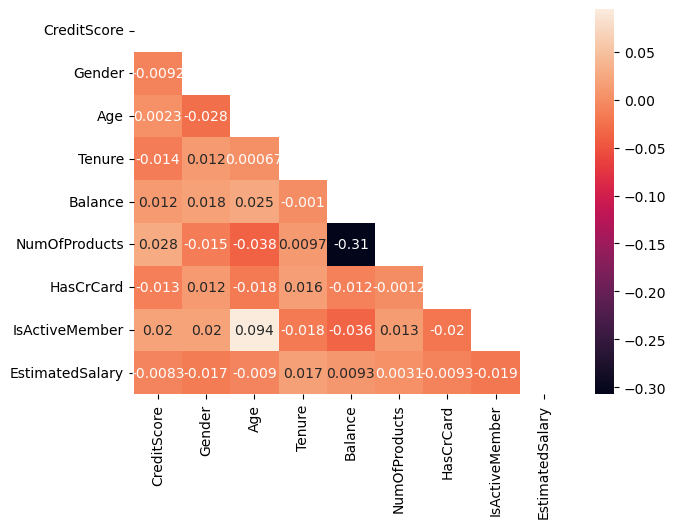

In [11]:
#correlation heatmap of all columns 

plt.figure(figsize=(7,5))
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)

#### Model Building

In [12]:
#dictionary to store models scores
scores_dict = {}

#### Logistic Regression

In [13]:
#training the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
score = roc_auc_score(y_train, y_pred)
print(score)

0.5152746574946953


In [14]:
#evaluating the model on validation data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
score = roc_auc_score(y_val, y_pred)
print(score)

0.5176639493707194


In [15]:
#Evaluating model on test data
lrf = LogisticRegression()
lrf.fit(X_full_train, y_full_train)
y_pred_lr = lrf.predict(X_test)
lr_score = roc_auc_score(y_test, y_pred_lr)
print(lr_score)

0.5250446915609349


In [16]:
#save logistic regression model score 
scores_dict['Logistic Regression'] = lr_score

#### Random Forest

In [17]:
#Training the random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_train)
score = roc_auc_score(y_train, y_pred_rf)
print(score)

1.0


In [18]:
#Evaluating the model on validation data 
y_pred_rf = rf.predict(X_val)
score = roc_auc_score(y_val, y_pred_rf)
print(score)


0.7095453220857726


In [19]:
#Evaluating model on test data
rfr = RandomForestClassifier()

rfr.fit(X_full_train, y_full_train)

y_pred_rfr = rfr.predict(X_test)

rf_score = roc_auc_score(y_test, y_pred_rfr)

print(rf_score)

0.6998223421386395


In [20]:
#saving model score 
scores_dict['Random Forest'] = rf_score

#### XGBoost

In [21]:
#specifying parameters for training the model
xgb_params = {
    'eta': 0.3,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1
}

In [22]:
#Training the model and evaluating on validation data 
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = df_train.columns)
dval = xgb.DMatrix(X_val, label=y_val, feature_names = df_val.columns)

xgb_clf = xgb.XGBClassifier(booster="gbtree", random_state=11)

xgb_clf = xgb.train(xgb_params, dtrain)

# y_pred_xgb = xgb_clf.predict(dtrain)
y_pred_xgb = xgb_clf.predict(dval)

score = roc_auc_score(y_val, y_pred_xgb)

print(score)

0.8262265593174568


In [23]:
#Evaluating the model on test data
d_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=df_train.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=df_test.columns)

xgb_clf = xgb.train(xgb_params, d_full_train)

y_pred_xgb = xgb_clf.predict(dtest)

xgb_score = roc_auc_score(y_test, y_pred_xgb)

print(xgb_score)

0.8311957387447728


In [24]:
scores_dict["XGBoost"] = xgb_score

#### Evaluating the best model

In [25]:
[item for item in scores_dict.items()]

[('Logistic Regression', 0.5250446915609349),
 ('Random Forest', 0.6998223421386395),
 ('XGBoost', 0.8311957387447728)]

#### Saving the best model

In [26]:
#Evaluating the model on test data
dmatrix = DMatrix
d_full_train = dmatrix(X_full_train, label=y_full_train, feature_names=df_train.columns)
dtest = dmatrix(X_test, label=y_test, feature_names=df_test.columns)

xgb_clf = xgb.train(xgb_params, d_full_train)

y_pred_xgb = xgb_clf.predict(dtest)

xgb_score = roc_auc_score(y_test, y_pred_xgb)

print(xgb_score)

0.8311957387447728


In [27]:
with open("../models/xgb.bin", "wb") as f_out:
    pickle.dump((xgb_clf, dmatrix), f_out)